In [25]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score,mean_squared_error
import warnings 
warnings.simplefilter('ignore')
root = '../data/P2_data/'
os.listdir(root)

['.ipynb_checkpoints',
 'Aroma-1 Unit 000 Split_Factor Calculation.xlsx',
 'Aroma-1_Unit_000_Simulation_Results_Rerun_001~050_Yu Final.xlsx',
 'FCFC Import Naphtha Composition Lab_001~100_R2.xlsx',
 'SplitFactor.csv',
 'test.csv',
 'train(add_split_factor).csv',
 'train(old).csv',
 'train.csv',
 '前50整合檔.xlsx',
 '欄位意義.xlsx',
 '開會紀錄.txt']

In [27]:
def mape(a, b):
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [2]:
def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

In [3]:
df = pd.read_csv(root+'train(add_split_factor).csv',index_col=0)
print(df.shape)
df.head()

(14023, 436)


,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input),Case Conditions_Feed Rate to C013 (Results),Case Conditions_C7+ in Light End (Results),Case Conditions_Heart Cut Prod. Rate (Results),Case Conditions_C6P- in Heart Cut (Results),Case Conditions_C10+ in Heart Cut (Results),Naphtha Properties_Naphtha Feed Rate,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
0,10.0,2.5,100.0,1.0,10.000001,2.500057,100.000198,1.000427,6.138641,118.000084,...,0.348342,0.378793,0.381912,0.397334,0.409138,0.433925,0.440811,0.451332,0.454764,0.0
1,10.0,5.0,100.0,1.0,10.000001,4.999882,100.000122,1.000401,6.249050,118.000000,...,0.336983,0.367462,0.370631,0.386031,0.397878,0.422758,0.429677,0.440263,0.443717,0.0
2,10.0,10.0,100.0,1.0,10.000001,10.000006,100.000008,0.999993,6.376052,118.000000,...,0.323372,0.354403,0.357728,0.373260,0.385311,0.410579,0.417606,0.428374,0.431884,0.0
3,10.0,2.5,100.0,1.5,10.000001,2.500020,100.000275,1.500293,6.316332,118.000000,...,0.334064,0.360351,0.362654,0.376680,0.387033,0.409416,0.415640,0.425230,0.428354,0.0
4,10.0,5.0,100.0,1.5,10.000001,5.000001,99.999817,1.499961,6.416863,118.000084,...,0.323809,0.350009,0.352356,0.366307,0.376672,0.399048,0.405285,0.414893,0.418027,0.0


In [4]:
case_col = df.columns[(df.columns.str.contains('Case'))&(df.columns.str.contains('Input'))].tolist()
case_col

['Case Conditions_Feed Rate to C013 (Input)',
 'Case Conditions_C7+ in Light End (Input)',
 'Case Conditions_Heart Cut Prod. Rate (Input)',
 'Case Conditions_C6P- in Heart Cut (Input)']

In [5]:
for i in case_col:
    print(df[i].nunique(),df[i].unique())

3 [10. 20. 30.]
3 [ 2.5  5.  10. ]
3 [100. 110.  90.]
24 [1.         1.5        2.         0.5        0.3        0.7
 0.49999709 0.50000062 0.49998139 0.25004868 0.25007036 0.2500357
 0.25       0.2        2.5        3.         0.1        0.05
 0.02       0.03       0.01       0.005      0.15       0.06      ]


In [6]:
s_col = get_group_col(df,'Individual Component')
print(len(s_col))

162


In [7]:
#for _ in range(3):
#    idx = np.random.randint(0,163)
#    fig = px.scatter_3d(df.sample(1000), 
#                        x = case_col[1], 
#                        y = case_col[2], 
#                        z = case_col[3],
#                        color = s_col[idx],
#                       )
#    fig.show()

In [8]:
train,test = train_test_split(df,test_size=0.2,random_state=42)

# build knn

In [9]:
ss = StandardScaler().fit(train[case_col])
knn = NearestNeighbors(n_neighbors=3).fit(ss.transform(train[case_col]))

# find neighbors

In [10]:
one_sample = test.sample(1)
one_sample[case_col]

,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input)
8286,30.0,2.5,100.0,2.0


In [11]:
dist,ind = knn.kneighbors(ss.transform(one_sample[case_col]))
dist = dist[0]
ind = ind[0]
print('distance is:{}\nindice is:{}'.format(dist,ind))
neighbor = train.iloc[ind,:]
neighbor[case_col]

distance is:[0. 0. 0.]
indice is:[2983 7654 8429]


,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input)
8253,30.0,2.5,100.0,2.0
2070,30.0,2.5,100.0,2.0
4951,30.0,2.5,100.0,2.0


In [12]:
neighbor.loc['neighbor_avg'] = neighbor.mean(axis=0)
neighbor.loc[['neighbor_avg']]

,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input),Case Conditions_Feed Rate to C013 (Results),Case Conditions_C7+ in Light End (Results),Case Conditions_Heart Cut Prod. Rate (Results),Case Conditions_C6P- in Heart Cut (Results),Case Conditions_C10+ in Heart Cut (Results),Naphtha Properties_Naphtha Feed Rate,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
neighbor_avg,30.0,2.5,100.0,2.0,30.000002,2.500074,100.000247,1.999941,4.196671,125.233332,...,0.384783,0.410278,0.413467,0.427013,0.438955,0.459669,0.466645,0.475184,0.478693,0.0


# check split factor

In [13]:
one_sample[s_col].append(neighbor.loc['neighbor_avg',s_col])

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
8286,0.0,0.0,0.0,0.986186,0.968339,0.939057,0.926245,0.927472,0.886888,0.826520,...,0.408552,0.431546,0.434011,0.446868,0.457963,0.476801,0.483362,0.491020,0.494326,0.0
neighbor_avg,0.0,0.0,0.0,0.984661,0.965291,0.933726,0.920017,0.921414,0.878547,0.807425,...,0.384783,0.410278,0.413467,0.427013,0.438955,0.459669,0.466645,0.475184,0.478693,0.0


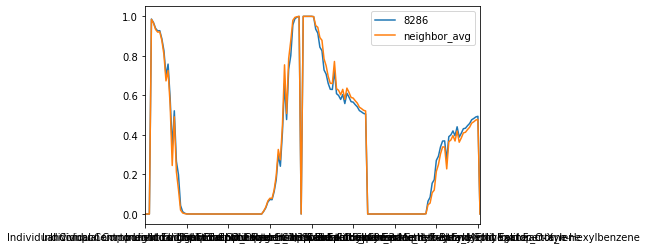

In [14]:
one_sample[s_col].append(neighbor.loc['neighbor_avg',s_col]).T.plot()
plt.show()

In [15]:
y_real = test[s_col]
y_real.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
7925,0.0,0.0,0.0,0.990195,0.978763,0.961007,0.953822,0.954510,0.934158,0.905917,...,0.179076,0.401805,0.437946,0.459482,0.491255,0.528237,0.541440,0.555570,0.561866,0.0
1034,0.0,0.0,0.0,0.989926,0.977547,0.957344,0.948730,0.949684,0.923787,0.882292,...,0.344192,0.377961,0.382146,0.398600,0.412110,0.438410,0.446123,0.457133,0.460967,0.0
8424,0.0,0.0,0.0,0.995476,0.989598,0.979580,0.974860,0.975325,0.956077,0.926918,...,0.388627,0.413795,0.417990,0.430836,0.443879,0.464121,0.471574,0.479867,0.483633,0.0
11171,0.0,0.0,0.0,0.995518,0.989724,0.979852,0.975127,0.975566,0.954749,0.923002,...,0.360722,0.385317,0.390461,0.402616,0.416694,0.436632,0.444630,0.452809,0.456882,0.0
9738,0.0,0.0,0.0,0.989136,0.975475,0.953445,0.944057,0.944918,0.916450,0.877845,...,0.412099,0.443604,0.449631,0.464399,0.480513,0.503691,0.512464,0.521714,0.526094,0.0


In [16]:
y_pred = pd.DataFrame(index=y_real.index,columns=s_col)
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
7925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
for idx in tqdm(test.index):
    # get X
    X = test.loc[[idx],case_col]
    # use knn
    dist,ind = knn.kneighbors(ss.transform(X))
    dist = dist[0]
    ind = ind[0]
    # find neighbor
    neighbor = train.iloc[ind]
    # caculate neighbor's avg
    neighbor.loc['neighbor_avg'] = neighbor.mean(axis=0)
    # predict = neighbor_avg's case_col
    y_pred.loc[[idx],:] = neighbor.loc[['neighbor_avg'],s_col].values

In [18]:
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
7925,0,0,0,0.98699,0.971238,0.946661,0.936469,0.937224,0.905846,0.867938,...,0.287016,0.339524,0.397117,0.403092,0.441452,0.465479,0.480803,0.489872,0.497553,0
1034,0,0,0,0.992214,0.982346,0.966197,0.959183,0.959843,0.937362,0.907012,...,0.388925,0.41887,0.424102,0.438537,0.453501,0.476007,0.484298,0.493353,0.497505,0
8424,0,0,0,0.994716,0.987882,0.976177,0.970588,0.971164,0.947866,0.904081,...,0.364197,0.389458,0.393407,0.40636,0.418917,0.439556,0.446803,0.455365,0.459027,0
11171,0,0,0,0.995166,0.988979,0.978421,0.97335,0.973899,0.952525,0.914482,...,0.348496,0.375027,0.379295,0.392631,0.405682,0.427343,0.434852,0.443884,0.447682,0
9738,0,0,0,0.98734,0.971412,0.945779,0.934863,0.935792,0.901874,0.85618,...,0.399135,0.427064,0.432722,0.446256,0.461469,0.482769,0.491225,0.499777,0.504034,0


In [19]:
y_real.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
7925,0.0,0.0,0.0,0.990195,0.978763,0.961007,0.953822,0.954510,0.934158,0.905917,...,0.179076,0.401805,0.437946,0.459482,0.491255,0.528237,0.541440,0.555570,0.561866,0.0
1034,0.0,0.0,0.0,0.989926,0.977547,0.957344,0.948730,0.949684,0.923787,0.882292,...,0.344192,0.377961,0.382146,0.398600,0.412110,0.438410,0.446123,0.457133,0.460967,0.0
8424,0.0,0.0,0.0,0.995476,0.989598,0.979580,0.974860,0.975325,0.956077,0.926918,...,0.388627,0.413795,0.417990,0.430836,0.443879,0.464121,0.471574,0.479867,0.483633,0.0
11171,0.0,0.0,0.0,0.995518,0.989724,0.979852,0.975127,0.975566,0.954749,0.923002,...,0.360722,0.385317,0.390461,0.402616,0.416694,0.436632,0.444630,0.452809,0.456882,0.0
9738,0.0,0.0,0.0,0.989136,0.975475,0.953445,0.944057,0.944918,0.916450,0.877845,...,0.412099,0.443604,0.449631,0.464399,0.480513,0.503691,0.512464,0.521714,0.526094,0.0


In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

res = pd.DataFrame(index=s_col,columns=['R2','MSE'])
for col in tqdm(s_col):
    res.loc[col,'R2'] = max(r2_score(y_real[col],y_pred[col]),0)
    res.loc[col,'MSE'] = mean_squared_error(y_real[col],y_pred[col])

res.loc['avg'] = res.mean(axis=0)
res['MSE'] = res['MSE'].apply(lambda x:round(x,4))
res

,R2,MSE
Individual Component to Light End Split Factor_Oxygen,1,0.0000
Individual Component to Light End Split Factor_Methane,1,0.0000
Individual Component to Light End Split Factor_Ethane,1,0.0000
Individual Component to Light End Split Factor_Propane,0,0.0201
Individual Component to Light End Split Factor_n-Butane,0,0.0091
Individual Component to Light End Split Factor_i-Pentane,0.404464,0.0002
Individual Component to Light End Split Factor_n-Pentane,0.341327,0.0004
Individual Component to Light End Split Factor_tr2-Pentene,0,0.0313
Individual Component to Light End Split Factor_Cyclopentane,0,0.0058
Individual Component to Light End Split Factor_3-Methylpentane,0,0.0061
